# COVID Data ETL Pipeline for BI

This project consists of creating an ETL pipeline whereby I collect COVID data from the World Data website, use that data to find useful analytical insights that could be displayed on PowerBI for BI reporting. The dashboard is intended to update everyday with new data by automating the processing and connecting each stage such that the data reflected on the dashboard is relevant. This script will achieve that goal and will be ran daily using windows task scheduler for simplicity.

**Table of Contents:**
1. Extract Data
2. Data Exploration and Cleansing (Transform)
3. Exploratory Data Analysis
4. Load

In [1]:
'''Data Analytics'''
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable # for geopandas aligning of legend and graph
import datetime

'''Webscraping'''
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC, wait
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support.ui import WebDriverWait
import time
import os # delete files off computer
import sys # exit

'''Connect to SQL'''
import pyodbc # sql
from sqlalchemy import create_engine # sql to insert df to sql
import urllib # for sql too

## 1. Extract Data

In [2]:
# open covid data website
path = r"C:\Users\Abdulkadir\Documents\Programming\chromedriver.exe"
driver = webdriver.Chrome(path)
driver.get('https://ourworldindata.org/covid-deaths')
wait = WebDriverWait(driver, 5)

# download csv file
try:
    csvLink = wait.until(EC.presence_of_element_located((By.XPATH, "/html/body/main/article/div[3]/div[2]/div/div/section[1]/div/div[1]/div[1]/div/div/a[2]")))
    csvLink.click()
except:
    print('Download failed')
    sys.exit()

    
# file path of csv
filepath = r"C:\Users\Abdulkadir\Downloads\owid-covid-data.csv"


# load csv file into df
x = 1
while True:
    try:
        csv = pd.read_csv(filepath)
        print('CSV succesfully downloaded.')
        break
    except:
        print(f'CSV downloading... {x}/100.')
        x += 1
        time.sleep(3)
    
    if x == 30:
        print('CSV Failed')
        #sys.exit()

# close driver
driver.close()
        
# delete the csv file off my computer so it does not interfere with downlaoding new data and names
try:
    os.remove(filepath)
    print('CSV successfully deleted.')
except:
    print('CSV does not exist.')

CSV downloading... 1/100.
CSV downloading... 2/100.
CSV downloading... 3/100.
CSV downloading... 4/100.
CSV downloading... 5/100.
CSV downloading... 6/100.
CSV downloading... 7/100.
CSV downloading... 8/100.
CSV downloading... 9/100.
CSV succesfully downloaded.
CSV successfully deleted.


## 2. Data Exploration and Cleansing (Transform)

In [3]:
df = csv.copy()

In [4]:
# see all columns
pd.set_option('display.max_columns', 500)

In [5]:
df.shape

(207545, 67)

In [6]:
df.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
207540,ZWE,Africa,Zimbabwe,2022-08-05,256444.0,0.0,9.714,5581.0,0.0,0.571,16034.240,0.000,0.607,348.954,0.000,0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.7,15993524.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
207541,ZWE,Africa,Zimbabwe,2022-08-06,256444.0,0.0,9.714,5581.0,0.0,0.571,16034.240,0.000,0.607,348.954,0.000,0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.7,15993524.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
207542,ZWE,Africa,Zimbabwe,2022-08-07,256447.0,3.0,9.857,5584.0,3.0,1.000,16034.427,0.188,0.616,349.141,0.188,0.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.7,15993524.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
207543,ZWE,Africa,Zimbabwe,2022-08-08,256487.0,40.0,15.000,5584.0,0.0,1.000,16036.928,2.501,0.938,349.141,0.000,0.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15993524.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
207544,ZWE,Africa,Zimbabwe,2022-08-09,256490.0,3.0,12.429,5586.0,2.0,1.143,16037.116,0.188,0.777,349.266,0.125,0.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15993524.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207545 entries, 0 to 207544
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    207545 non-null  object 
 1   continent                                   195548 non-null  object 
 2   location                                    207545 non-null  object 
 3   date                                        207545 non-null  object 
 4   total_cases                                 199158 non-null  float64
 5   new_cases                                   198872 non-null  float64
 6   new_cases_smoothed                          197695 non-null  float64
 7   total_deaths                                180373 non-null  float64
 8   new_deaths                                  180327 non-null  float64
 9   new_deaths_smoothed                         179159 non-null  float64
 

In [8]:
for col_name in df.columns:
    print(f'{col_name}: {df[col_name].isnull().sum()}')

iso_code: 0
continent: 11997
location: 0
date: 0
total_cases: 8387
new_cases: 8673
new_cases_smoothed: 9850
total_deaths: 27172
new_deaths: 27218
new_deaths_smoothed: 28386
total_cases_per_million: 9302
new_cases_per_million: 9588
new_cases_smoothed_per_million: 10760
total_deaths_per_million: 28074
new_deaths_per_million: 28120
new_deaths_smoothed_per_million: 29283
reproduction_rate: 52133
icu_patients: 180155
icu_patients_per_million: 180155
hosp_patients: 178238
hosp_patients_per_million: 178238
weekly_icu_admissions: 200751
weekly_icu_admissions_per_million: 200751
weekly_hosp_admissions: 194073
weekly_hosp_admissions_per_million: 194073
total_tests: 128160
new_tests: 132144
total_tests_per_thousand: 128160
new_tests_per_thousand: 132144
new_tests_smoothed: 103582
new_tests_smoothed_per_thousand: 103582
positive_rate: 111625
tests_per_case: 113487
tests_units: 100759
total_vaccinations: 149575
people_vaccinated: 152221
people_fully_vaccinated: 154908
total_boosters: 177980
new_vac

### 2.1 Understanding the data

In [9]:
np.unique(df['iso_code'])

array(['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA',
       'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL',
       'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL',
       'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV',
       'CRI', 'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA',
       'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST',
       'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI',
       'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM',
       'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA',
       'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO',
       'MDA', 'MDG',

Explore OWID codes

In [10]:
explore_code = ['OWID_AFR', 'OWID_ASI', 'OWID_CYN',
       'OWID_EUN', 'OWID_EUR', 'OWID_HIC', 'OWID_INT', 'OWID_KOS',
       'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_OCE', 'OWID_SAM',
       'OWID_UMC', 'OWID_WRL']

In [11]:
df.loc[df['iso_code'].isin(explore_code)].groupby(['iso_code', 'location']).agg({'population':'max'})

,,population
iso_code,location,
OWID_AFR,Africa,1.392394e+09
OWID_ASI,Asia,4.693235e+09
OWID_CYN,Northern Cyprus,NaN
OWID_EUN,European Union,4.475935e+08
OWID_EUR,Europe,7.486552e+08
OWID_HIC,High income,1.241374e+09
OWID_INT,International,NaN
OWID_KOS,Kosovo,1.782115e+06
OWID_LIC,Low income,7.019270e+08


**Note:** 
- OWID_AFR == Africa
- OWID_ASI == Asia
- OWID_NAM == North America
- OWID_OCE == Oceania
- OWID_SAM == South America
- OWID_EUR == Europe
---
- OWID_EUN == European Union
- OWID_HIC == High income
- OWID_LIC == Low income
- OWID_LMC == Lower middle income
- OWID_UMC == upper middle income
---
- OWID_INT == International
- OWID_WRL == World

Additionally, if NaN, it most likely means it was 0 at the time. Therefore fillna(0)

In [12]:
df.fillna(0, inplace=True)

In [13]:
df.isnull().sum()

iso_code                                   0
continent                                  0
location                                   0
date                                       0
total_cases                                0
                                          ..
human_development_index                    0
excess_mortality_cumulative_absolute       0
excess_mortality_cumulative                0
excess_mortality                           0
excess_mortality_cumulative_per_million    0
Length: 67, dtype: int64

Taking features of interest:

In [14]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

- Remove columns with: _per _, _smoothed
- Keep hospital_beds_per_thousand

Reduce columns to use:

In [15]:
features_to_keep = []
key_words_to_drop = "_per_|_smoothed"

In [16]:
import re

def remove(word):
    for col_name in df.columns:
        if re.search(word, col_name):
            pass
        else:
            features_to_keep.append(col_name)

In [17]:
remove(key_words_to_drop)

In [18]:
features_to_keep.append('hospital_beds_per_thousand')

In [19]:
print(features_to_keep)

['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate', 'icu_patients', 'hosp_patients', 'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests', 'positive_rate', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'life_expectancy', 'human_development_index', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality', 'hospital_beds_per_thousand']


Add month and year column

In [20]:
from datetime import datetime

df['date'] = pd.to_datetime(df['date'])

In [21]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day

In [22]:
df_small = df[features_to_keep]

## 3. Exploratory Data Analysis

In [23]:
df.shape

(207545, 70)

In [24]:
# rid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [25]:
df_small.describe()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,weekly_icu_admissions,weekly_hosp_admissions,total_tests,new_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,hospital_beds_per_thousand
count,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000,207545.00000
mean,3687234.69988,12061.68316,60173.66043,128.42068,0.72247,113.29727,594.87142,14.38005,365.95213,8068207.06496,24444.21250,0.04516,71946837.32753,32447243.63176,26369063.50518,6953675.35312,232553.51858,37.82979,142350696.55506,406.94243,25.26347,7.19588,4.56374,7.28790,214.64910,7.22208,6.63163,20.12727,20.55170,68.89458,0.58079,1503.31094,0.32553,0.49945,2.25457
std,23637966.40767,85473.22470,335183.94698,710.03954,0.53105,953.50586,4375.88887,132.95864,3736.25661,52976780.28327,152787.04527,0.09220,582006064.91661,268209291.72242,230505575.58132,78800102.34378,1882794.44031,28.55542,694111251.23053,1994.58466,14.26769,6.50800,4.33473,16.15122,147.55728,5.22321,9.83205,19.16948,32.13868,19.47241,0.31891,24150.25034,3.07275,5.65482,2.57451
min,0.00000,0.00000,0.00000,0.00000,-0.10000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-37726.10000,-28.45000,-95.92000,0.00000
25%,2182.00000,0.00000,27.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.33000,821626.00000,21.18800,18.60000,2.58100,1.52500,0.00000,114.31600,3.94000,0.00000,0.00000,0.00000,66.70000,0.48000,0.00000,0.00000,0.00000,0.00000
50%,34658.00000,49.00000,541.00000,0.00000,0.85000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,40.74000,7425058.00000,77.39000,27.60000,4.80000,2.89100,0.20000,217.06600,6.82000,1.60000,19.10000,0.00000,74.47000,0.70400,0.00000,0.00000,0.00000,1.50000
75%,402365.00000,907.00000,6642.00000,11.00000,1.09000,0.00000,0.00000,0.00000,0.00000,784734.00000,3192.00000,0.04690,125646.00000,37317.00000,876.00000,0.00000,0.00000,60.19000,32981641.00000,207.97300,37.40000,11.23200,7.04900,3.40000,304.19500,10.08000,8.80000,35.60000,36.79100,78.88000,0.81400,0.00000,0.00000,0.00000,3.32000
max,586435868.00000,4079467.00000,6423686.00000,18191.00000,6.15000,28891.00000,154513.00000,4838.00000,153988.00000,9214000000.00000,35855632.00000,1.00000,12415322457.00000,5312282099.00000,4883058918.00000,2308579861.00000,49672388.00000,100.00000,7909295152.00000,20546.76600,48.20000,27.04900,18.49300,77.60000,724.41700,30.53000,44.00000,78.10000,100.00000,86.75000,0.95700,1219077.90000,76.55000,375.98000,13.80000


- Data is right skewed as COVID-19 hit a peak early on and died down.
- Mean new deaths per case is around 1%
- Mean total deaths per case is around 1.6%
- Mean hospitalised patient per new case is around 4.93%
- People who are fully vaccinated against the total number of vaccinations is around 36%

In [26]:
df['continent'].value_counts()

Africa           48053
Europe           45050
Asia             44737
North America    32060
Oceania          14090
0                11997
South America    11558
Name: continent, dtype: int64

In [27]:
df[df['continent'] == 0].head(1)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,month,year,day
898,OWID_AFR,0,Africa,2020-02-13,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1392394303.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2,2020,13


In [28]:
df[df['continent'] == 0]['iso_code'].value_counts()

OWID_ASI    931
OWID_WRL    931
OWID_LMC    931
OWID_UMC    931
OWID_HIC    931
OWID_NAM    931
OWID_EUR    930
OWID_EUN    930
OWID_OCE    928
OWID_INT    915
OWID_AFR    909
OWID_SAM    900
OWID_LIC    899
Name: iso_code, dtype: int64

In [29]:
df[df['continent'] != 0].head(1)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,month,year,day
0,AFG,Asia,Afghanistan,2020-02-24,5.00000,5.00000,0.00000,0.00000,0.00000,0.00000,0.12500,0.12500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.33000,40099462.00000,54.42200,18.60000,2.58100,1.33700,1803.98700,0.00000,597.02900,9.59000,0.00000,0.00000,37.74600,0.50000,64.83000,0.51100,0.00000,0.00000,0.00000,0.00000,2,2020,24


- continent == 0 means everything but countries filter, continent != 0 means country filter

In [30]:
countries = df[df['continent'] != 0]

In [31]:
countries.shape

(195548, 70)

### 3.1 Features against time for world data

In [32]:
def timeplot(feature):
    plt.figure(figsize = (11,7))
    sns.lineplot(x='date', y=feature, data=df[df['iso_code'] == 'OWID_WRL']).set_title(f'{feature} vs date')
    plt.show()

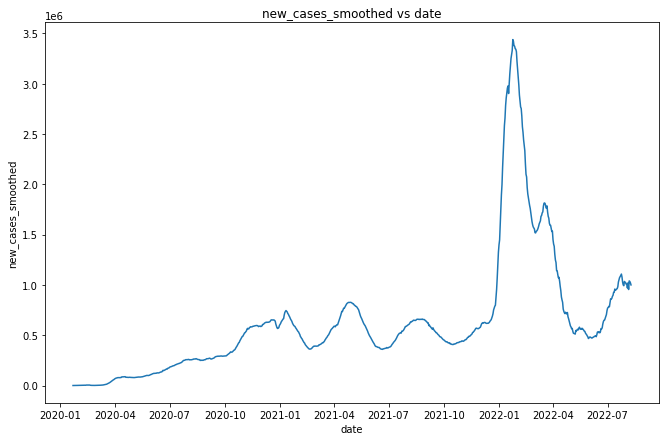

In [33]:
timeplot('new_cases_smoothed')

- New cases per day in the world peaked some time between January and February 2022 and it seems like it is starting to climb again.

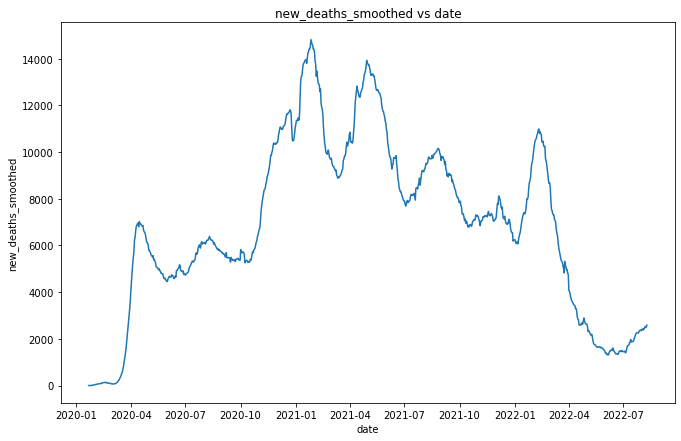

In [34]:
timeplot('new_deaths_smoothed')

- Deaths have been decreasing since early 2021 although it spiked around the time the cases spiked. This perhaps may be linked to vaccinations.

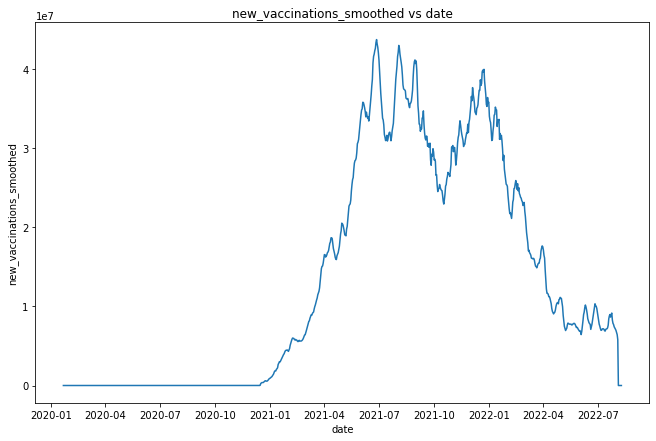

In [35]:
timeplot('new_vaccinations_smoothed')

- COVID vaccines were introduced at around the end of 2020 and shortly after that, the deaths started to decrease.

Exploring continental data:

In [36]:
continents = ['OWID_AFR', 'OWID_ASI', 'OWID_NAM', 'OWID_OCE', 'OWID_SAM', 'OWID_EUR']

How do features distribute among the continents?

In [37]:
def piechart(feature):
    table = df[df['iso_code'].isin(continents)].groupby(['iso_code', 'location']).agg({'population':'max', feature:'max'}).reset_index()
    table[f'{feature}_per_population'] = (table[feature] / table['population']) * 100
    
    labels = table['location']
    data = table[f'{feature}_per_population']
    colors = sns.color_palette('pastel')
    
    plt.figure(figsize = (12,8))
    plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%')
    plt.title(f'{feature}_per_population vs continent')
    plt.show()
    return table

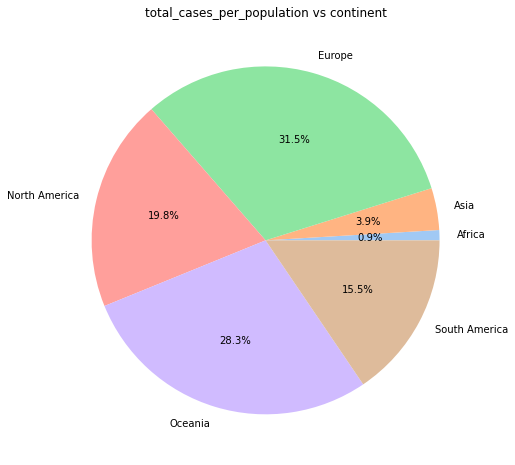

In [38]:
a = piechart('total_cases')

- Europe had the most cases for its population followed by Oceania. Africa seems to be mostly not infected. Perhaps a better metric would be to look at the feature against the total_cases

In [39]:
def piechartcases(feature):
    table = df[df['iso_code'].isin(continents)].groupby(['iso_code', 'location']).agg({'total_cases':'max', feature:'max'}).reset_index()
    table[f'{feature}_per_total_cases'] = (table[feature] / table['total_cases']) * 100
    
    labels = table['location']
    data = table[f'{feature}_per_total_cases']
    colors = sns.color_palette('pastel')
    
    plt.figure(figsize = (12,8))
    plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%')
    plt.title(f'{feature}_per_total_cases vs continent')
    plt.show()
    return table

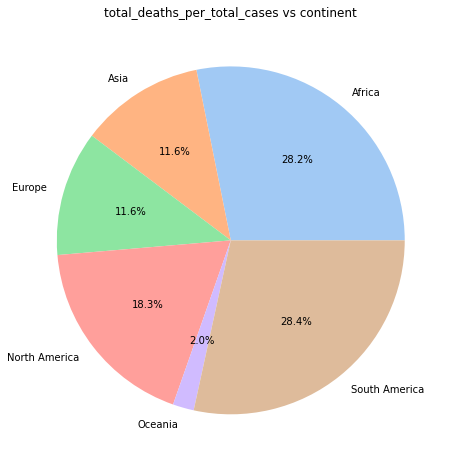

In [40]:
b = piechartcases('total_deaths')

- Now, Africa seems to be one of continents that was mostly affected by deaths. It had a 2% death ratio per infected and thi amounts to about 28% of the continents total deaths per total cases.

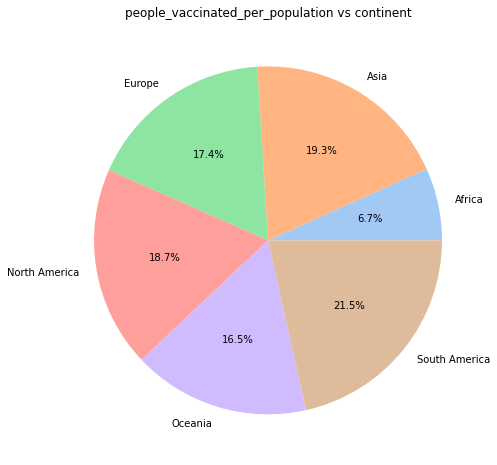

In [41]:
c = piechart('people_vaccinated')

- Each continent is almost equally distributed in total vaccinations for its population except from Africa, which is much less.

### 3.2 Exploring features against population

In [42]:
def population_table(feature):
    table = countries.groupby(['iso_code', 'location']).agg({'population':'max', feature:'max'})
    table = table[table['population'] > 0]
    table[f'{feature}_per_population'] = table[feature] / table['population']
    table = table.sort_values(f'{feature}_per_population', ascending=False).head(10).reset_index()
    return table

In [43]:
def population_plot(table):
    plt.figure(figsize = (10,5))
    sns.barplot(x=table.iloc[:,1], y=table.iloc[:,-1], data=table)
    plt.xticks(rotation=45)

In [44]:
population_table('total_deaths')

,iso_code,location,population,total_deaths,total_deaths_per_population
0,PER,Peru,33715472.00000,214694.00000,0.00637
1,BGR,Bulgaria,6885868.00000,37460.00000,0.00544
2,BIH,Bosnia and Herzegovina,3270943.00000,15930.00000,0.00487
3,HUN,Hungary,9709786.00000,46886.00000,0.00483
4,GEO,Georgia,3757980.00000,16869.00000,0.00449
5,MKD,North Macedonia,2103330.00000,9398.00000,0.00447
6,MNE,Montenegro,627859.00000,2756.00000,0.00439
7,HRV,Croatia,4060135.00000,16434.00000,0.00405
8,CZE,Czechia,10510750.00000,40587.00000,0.00386
9,MDA,Moldova,3061506.00000,11630.00000,0.00380


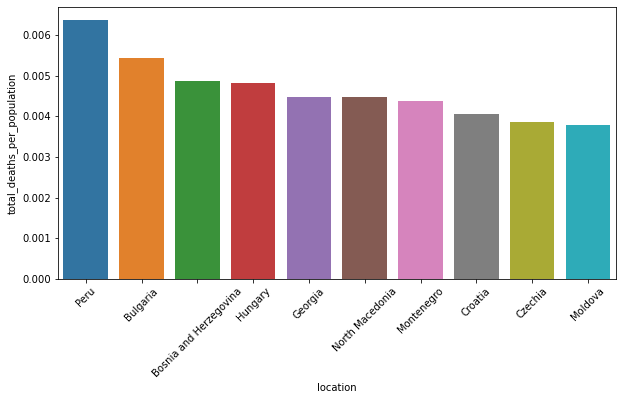

In [45]:
population_plot(population_table('total_deaths'))

- The top 10 countries who have suffered from COVID-19 in terms of death in the world.

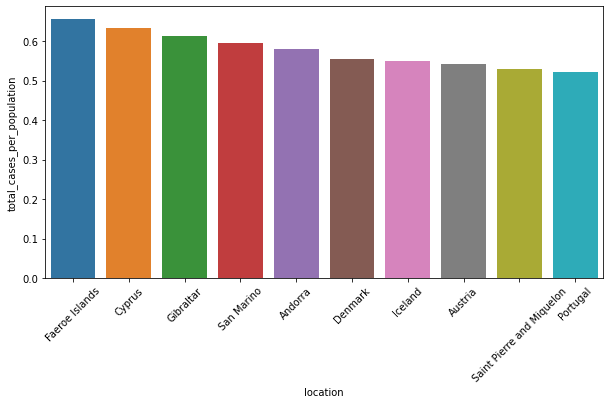

In [46]:
population_plot(population_table('total_cases'))

- The countries that have had the most cases for their population in the world.

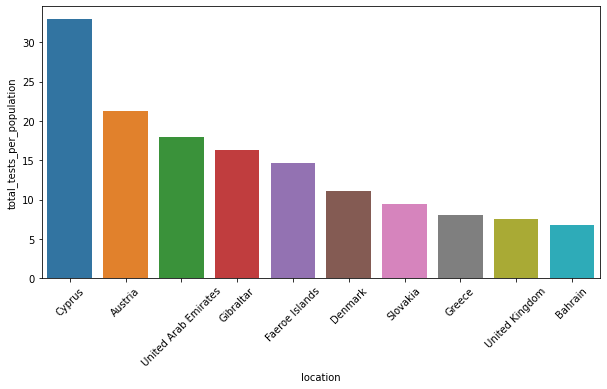

In [47]:
population_plot(population_table('total_tests'))

- The countries that have been tested the most for their population in the world.

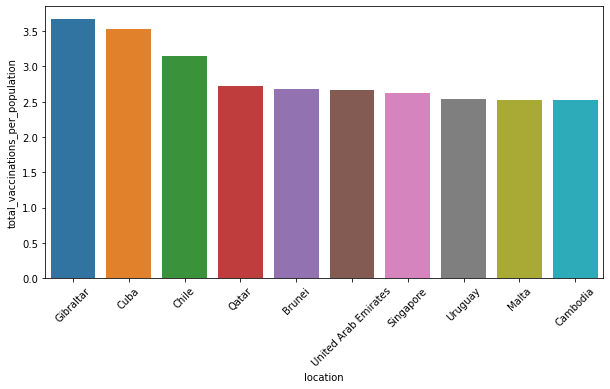

In [48]:
population_plot(population_table('total_vaccinations'))

- The countries that their been vaccinated the most for their population.

If we compare the vaccination rate for the country with the highest death rate i.e. Peru to Gibraltar, the country with highest vaccination rate, we can perhaps find a trend:

In [49]:
def timeplotcountry(country_1, country_2, feature):
    countries = [country_1, country_2]
    plt.figure(figsize = (11,7))
    sns.lineplot(x='date', y=feature, data=df[df['location'].isin(countries)], hue='location').set_title(f'{feature} vs date')
    plt.show()

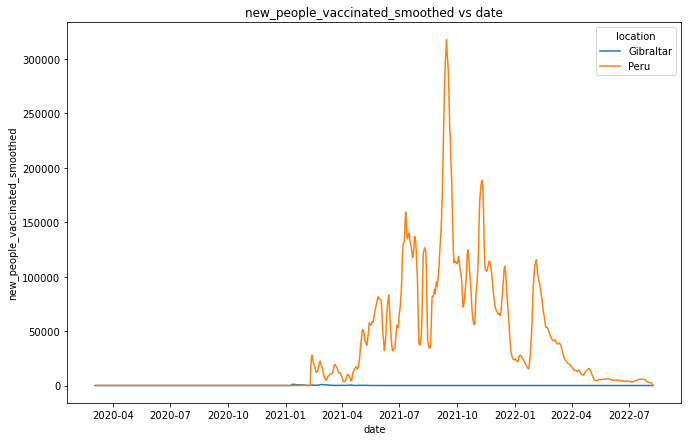

In [50]:
timeplotcountry('Gibraltar', 'Peru', 'new_people_vaccinated_smoothed')

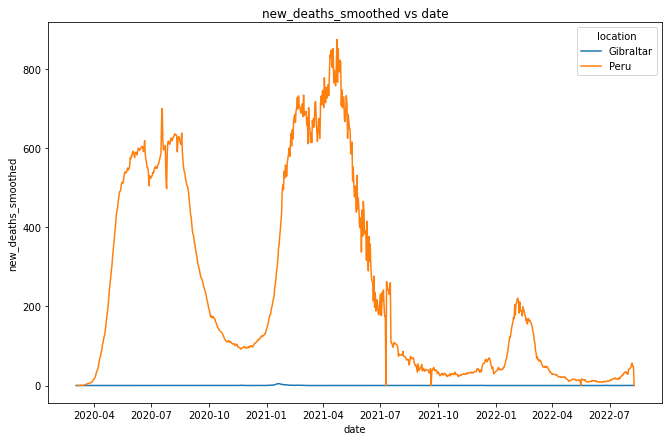

In [51]:
timeplotcountry('Gibraltar', 'Peru', 'new_deaths_smoothed')

In [52]:
df[df['location'] == 'Peru']['population'].max()

33715472.0

In [53]:
df[df['location'] == 'Gibraltar']['population'].max()

32670.0

- Not a good indicator as the population difference is significant. Hence, test on countries with similar population.

In [54]:
df[df['continent'] != 0].groupby('location').agg({'population':'max'}).sort_values('population', ascending=False).head(20)

,population
location,
China,1425893464.00000
India,1407563842.00000
United States,336997624.00000
Indonesia,273753191.00000
Pakistan,231402116.00000
Brazil,214326223.00000
Nigeria,213401323.00000
Bangladesh,169356251.00000
Russia,145102755.00000


In [55]:
def timeplotcountry(country_1, country_2, country_3, feature):
    countries = [country_1, country_2, country_3]
    plt.figure(figsize = (11,7))
    sns.lineplot(x='date', y=feature, data=df[df['location'].isin(countries)], hue='location').set_title(f'{feature} vs date')
    plt.show()

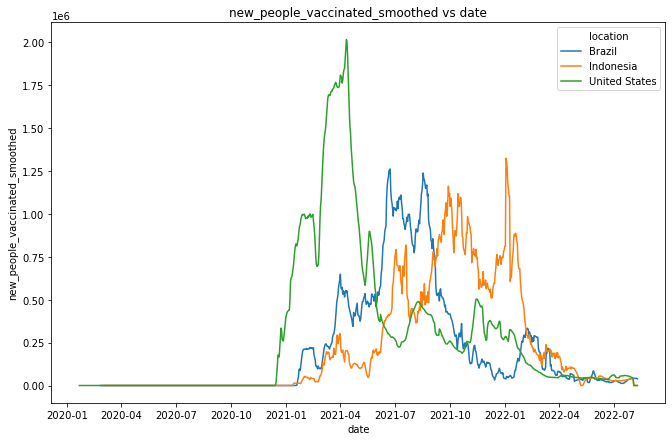

In [56]:
timeplotcountry('Indonesia', 'United States', 'Brazil', 'new_people_vaccinated_smoothed')

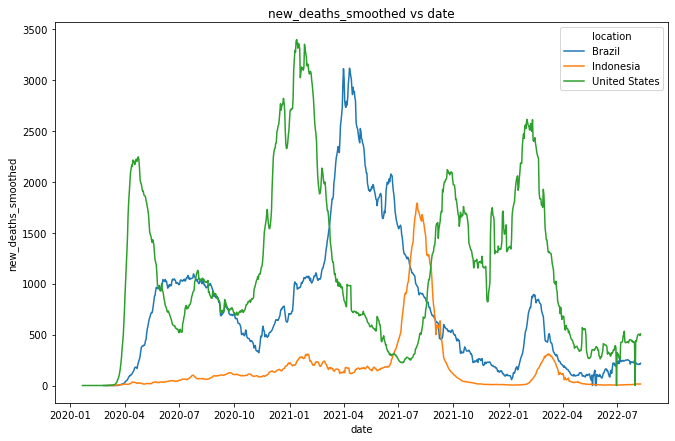

In [57]:
timeplotcountry('Indonesia', 'United States', 'Brazil', 'new_deaths_smoothed')

- At the time Indonesia were late in getting the vaccine relative to the US, The US deaths started to decrease whilst Indonesia's deaths started to increase. When Indonesia started to vaccine their people, the deaths dropped off significantly. 
- The deaths of Indonesia before the vaccine were low compared to the US. This signifies there are more factors than just a vaccine. Also, the US deaths also increased significantly again, even after the vaccine.
- Brazil seems to follow the same trend of Indonesia after being vaccinated such that the deaths also reduce significantly and stay low.

### 3.3 Exploring feature against feature

**Fully vaccinated vs partly vaccinated**

In [58]:
df.loc[df['iso_code'] == 'OWID_WRL', ['people_vaccinated', 'people_fully_vaccinated']]

,people_vaccinated,people_fully_vaccinated
204014,0.00000,0.00000
204015,0.00000,0.00000
204016,0.00000,0.00000
204017,0.00000,0.00000
204018,0.00000,0.00000
...,...,...
204940,5310853510.00000,4880321831.00000
204941,5311120489.00000,4880931553.00000
204942,5311285722.00000,4881406133.00000
204943,5312112633.00000,4882591292.00000


In [59]:
def vaccination_piechart(feature):
    plt.figure(figsize = (11,7))
    df.loc[df['iso_code'] == 'OWID_WRL', ['people_vaccinated', feature]].max().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)
    plt.ylabel('')
    plt.show()

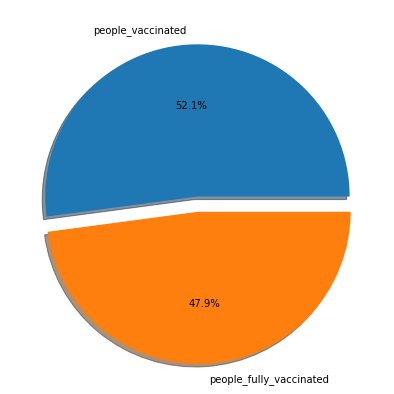

In [60]:
vaccination_piechart('people_fully_vaccinated')

- For the people that have been vaccinated, almost half of them are fully vaccinated.

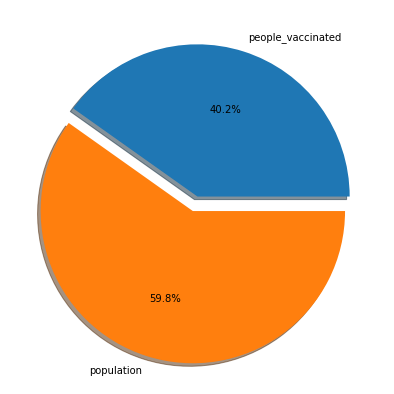

In [61]:
vaccination_piechart('population')

- Around 40% of the world are vaccinated.

How does the full vs partial vaccination vary across each continent?

In [62]:
world_vaccination = df.loc[df['iso_code'].isin(continents), ['iso_code', 'location', 'population', 'people_vaccinated', 'people_fully_vaccinated']].groupby(['iso_code', 'location']).max().reset_index()
world_vaccination

,iso_code,location,population,people_vaccinated,people_fully_vaccinated
0,OWID_AFR,Africa,1392394303.00000,371836386.00000,293278107.00000
1,OWID_ASI,Asia,4693235454.00000,3584029107.00000,3352719597.00000
2,OWID_EUR,Europe,748655221.00000,516477947.00000,494426625.00000
3,OWID_NAM,North America,596315269.00000,441112084.00000,382637684.00000
4,OWID_OCE,Oceania,44491772.00000,29055001.00000,27871012.00000
5,OWID_SAM,South America,433956670.00000,369771574.00000,332125893.00000


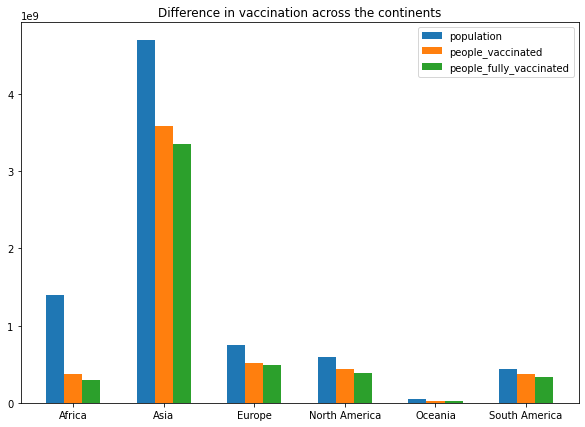

In [63]:
plt.figure(figsize = (10,7))

x = world_vaccination['location']

y = world_vaccination['population']
z = world_vaccination['people_vaccinated']
k = world_vaccination['people_fully_vaccinated']

X_axis = np.arange(len(x))

plt.bar(X_axis - 0.2, y, 0.2, label = 'population')
plt.bar(X_axis, z, 0.2, label = 'people_vaccinated')
plt.bar(X_axis + 0.2, k, 0.2, label = 'people_fully_vaccinated')

plt.xticks(X_axis, x)
plt.ylabel("")
plt.title("Difference in vaccination across the continents")
plt.legend()
plt.show()

- Africa is least vaccinated relative to its population.

In [64]:
def piechartcontinents():
    table = df.loc[df['iso_code'].isin(continents), ['iso_code', 'location', 'population', 'people_vaccinated', 'people_fully_vaccinated']].groupby(['iso_code', 'location']).max().reset_index()
    table[f'people_fully_vaccinated_per_people_vaccinated'] = table['people_fully_vaccinated'] / table['people_vaccinated']
    
    labels = table['location']
    data = table[f'people_fully_vaccinated_per_people_vaccinated']
    colors = sns.color_palette('pastel')
    
    plt.figure(figsize = (12,8))
    plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%')
    plt.title(f'people_fully_vaccinated_per_people_vaccinated vs continent')
    plt.show()

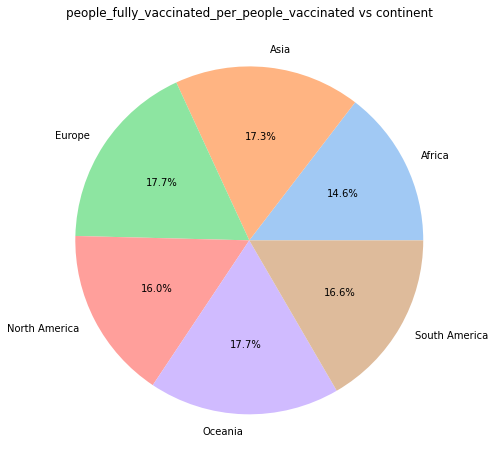

In [65]:
piechartcontinents()

- Full vs partial vaccination is similar across each continent.

**Testing vs Features**

In [66]:
def test_series(feature_1, feature_2, feature_3, feature_4):
    table = countries.groupby('date').agg({feature_1:'max', feature_2:'max', feature_3:'max', feature_4:'max'})
    plot , ax = plt.subplots(4, 1, figsize=(18,20))
    sns.lineplot(x='date', y=feature_1, data=table, ax = ax[0]).set_title(f'{feature_1} vs date')
    sns.lineplot(x='date', y=feature_2, data=table, ax = ax[1]).set_title(f'{feature_2} vs date')
    sns.lineplot(x='date', y=feature_3, data=table, ax = ax[2]).set_title(f'{feature_3} vs date')
    sns.lineplot(x='date', y=feature_4, data=table, ax = ax[3]).set_title(f'{feature_4} vs date')
    plt.show()

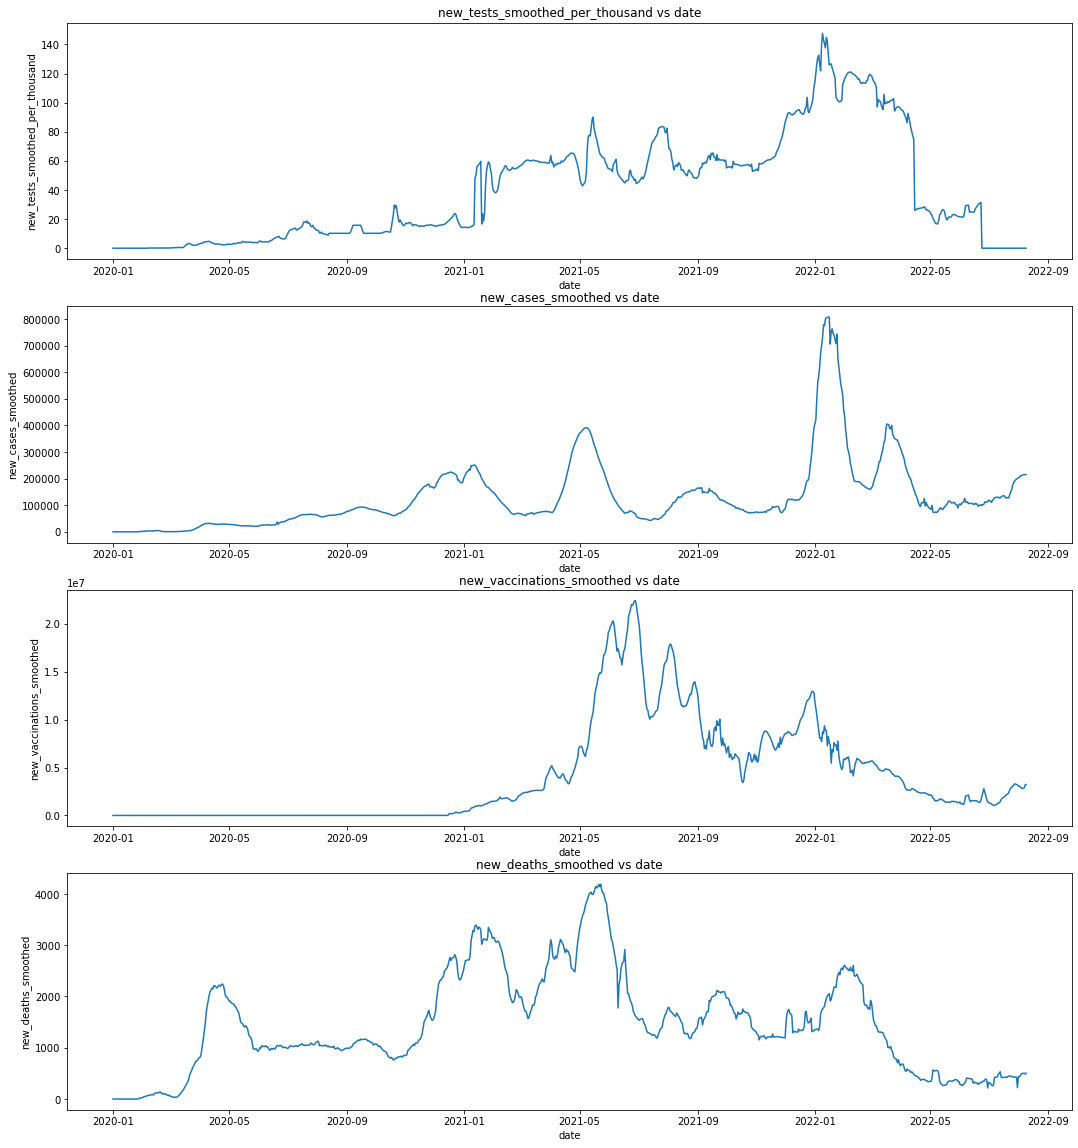

In [67]:
test_series('new_tests_smoothed_per_thousand', 'new_cases_smoothed', 'new_vaccinations_smoothed', 'new_deaths_smoothed')

- As testing increased, the number of cases increased as more people with COVID were able to be indentified.
- Vaccinations will peak at one point and decrease as the aim of the vaccination was to try vaccinate as many people as possible. It most likely affected the number of people that died as its severity reduced but it did not stop other people from catching COVID.

### 3.4 COVID vs Year

In [68]:
def time_feature(feature, time):
    table = countries.groupby(time).agg({feature:'sum'}).reset_index()
    plt.figure(figsize = (6,4))
    sns.barplot(x=time, y=feature, data=table).set_title(f'{feature} vs {time}')
    plt.show()

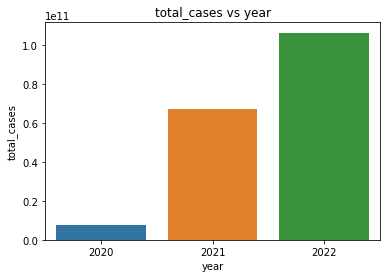

In [69]:
time_feature('total_cases', 'year')

- Total cases increased each year.

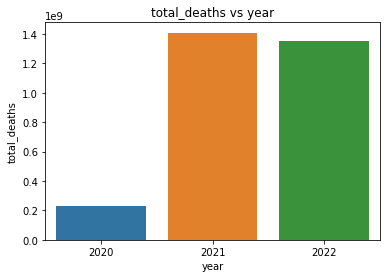

In [70]:
time_feature('total_deaths', 'year')

- Deaths decreased after 2021.

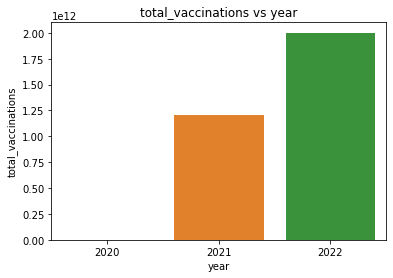

In [71]:
time_feature('total_vaccinations', 'year')

- Vaccinations increased by almost double in 2022.

### 3.5 World Maps

#### 3.5.1 Cleaning 

Load geopandas coordinates to map to df

In [72]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.00000,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.00000,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.50000,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.00000,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.00000,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [73]:
world[['iso_a3', 'continent', 'name']]

,iso_a3,continent,name
0,FJI,Oceania,Fiji
1,TZA,Africa,Tanzania
2,ESH,Africa,W. Sahara
3,CAN,North America,Canada
4,USA,North America,United States of America
...,...,...,...
172,SRB,Europe,Serbia
173,MNE,Europe,Montenegro
174,-99,Europe,Kosovo
175,TTO,North America,Trinidad and Tobago


In [74]:
df_world = df[['iso_code', 'continent', 'location']].groupby(['iso_code', 'continent', 'location']).count().reset_index()
df_world

,iso_code,continent,location
0,ABW,North America,Aruba
1,AFG,Asia,Afghanistan
2,AGO,Africa,Angola
3,AIA,North America,Anguilla
4,ALB,Europe,Albania
...,...,...,...
239,WSM,Oceania,Samoa
240,YEM,Asia,Yemen
241,ZAF,Africa,South Africa
242,ZMB,Africa,Zambia


Geopandas only has 177 countries that can be mapped out of the 244 available countries in the df.

- Step 1: Compare iso codes

In [75]:
geo_list = world['iso_a3'].to_list()
df_list = df_world['iso_code'].to_list()

In [76]:
def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    return list(c - d)

In [77]:
diff(df_list, geo_list)

['ATG',
 'OWID_WRL',
 'SXM',
 'TON',
 'LIE',
 'MHL',
 'OWID_HIC',
 'SYC',
 'OWID_OCE',
 'FSM',
 'BHR',
 'WSM',
 'FRA',
 'IMN',
 'SHN',
 'CPV',
 'DMA',
 'TCA',
 'GUM',
 'OWID_AFR',
 'GGY',
 'HKG',
 'PCN',
 'OWID_SAM',
 'COM',
 'VCT',
 'PLW',
 'COK',
 'KIR',
 'MLT',
 'BES',
 'FRO',
 'OWID_LMC',
 'WLF',
 'SGP',
 'TUV',
 'KNA',
 'VAT',
 'MAC',
 'OWID_NAM',
 'CYM',
 'OWID_CYN',
 'OWID_EUR',
 'ATA',
 '-99',
 'AND',
 'OWID_UMC',
 'MUS',
 'OWID_KOS',
 'MCO',
 'STP',
 'BRB',
 'NIU',
 'ATF',
 'GIB',
 'OWID_LIC',
 'PYF',
 'OWID_ASI',
 'ABW',
 'CUW',
 'GRD',
 'VIR',
 'MNP',
 'NOR',
 'JEY',
 'SMR',
 'MSR',
 'SPM',
 'OWID_INT',
 'BMU',
 'OWID_EUN',
 'MDV',
 'TKL',
 'AIA',
 'VGB',
 'LCA',
 'NRU']

Deal with -99

In [78]:
world[world['iso_a3'] == '-99']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.00000,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,67106161,Europe,France,-99,2699000.00000,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
160,265100,Asia,N. Cyprus,-99,3600.00000,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
167,3500000,Africa,Somaliland,-99,12250.00000,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
174,1895250,Europe,Kosovo,-99,18490.00000,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [79]:
df_world[df_world['location'].isin(world[world['iso_a3'] == '-99']['name'])]

,iso_code,continent,location
67,FRA,Europe,France
151,NOR,Europe,Norway
163,OWID_KOS,Europe,Kosovo


In [80]:
world.at[21,'iso_a3'] = 'NOR'
world.at[43,'iso_a3'] = 'FRA'
world.at[174,'iso_a3'] = 'OWID_KOS'

Deal with other 3:

In [81]:
df_world[df_world['location'].str.contains('Somali')]

,iso_code,continent,location
198,SOM,Africa,Somalia


- No Somaliland in my df

In [82]:
df_world[df_world['location'].str.contains('Cyprus')]

,iso_code,continent,location
49,CYP,Europe,Cyprus
158,OWID_CYN,Asia,Northern Cyprus


In [83]:
world.at[160,'iso_a3'] = 'OWID_CYN'

Deal with the rest:

In [84]:
pd.set_option('display.max_rows', 208)

In [85]:
world[world['iso_a3'].isin(diff(df_list, geo_list))]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,NOR,364700.00000,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
23,140,Seven seas (open ocean),Fr. S. Antarctic Lands,ATF,16.00000,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940..."
43,67106161,Europe,France,FRA,2699000.00000,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
159,4050,Antarctica,Antarctica,ATA,810.00000,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140..."
160,265100,Asia,N. Cyprus,OWID_CYN,3600.00000,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
167,3500000,Africa,Somaliland,-99,12250.00000,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
174,1895250,Europe,Kosovo,OWID_KOS,18490.00000,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [86]:
print(df_world[df_world['location'].str.contains('Antarctic')])

Empty DataFrame
Columns: [iso_code, continent, location]
Index: []


- The codes in world dataset but not in df

In [87]:
test = df_world[(df_world['iso_code'].isin(diff(df_list, geo_list)))]
test[test['continent'] != 0]

,iso_code,continent,location
0,ABW,North America,Aruba
3,AIA,North America,Anguilla
5,AND,Europe,Andorra
9,ATG,North America,Antigua and Barbuda
16,BES,North America,Bonaire Sint Eustatius and Saba
20,BHR,Asia,Bahrain
25,BMU,North America,Bermuda
28,BRB,North America,Barbados
41,COK,Oceania,Cook Islands
43,COM,Africa,Comoros


In [88]:
for country in test['location']:
    print(world[world['name'].str.contains(country.split(' ')[0])]['name'])

Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
17    Dominican Rep.
Name: name, dtype: object
43    France
Name: name, dtype: object
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Series([], Name: name, dtype: object)
Se

In [89]:
world[world['name'].str.contains('Aruba')]['name']

Series([], Name: name, dtype: object)

In [90]:
print(df_world[df_world['location'].str.contains('Dominican')])
print(df_world[df_world['location'].str.contains('South')])
print(df_world[df_world['location'].str.contains('Central')])

   iso_code      continent            location
55      DOM  North America  Dominican Republic
     iso_code continent       location
110       KOR      Asia    South Korea
168  OWID_SAM         0  South America
201       SSD    Africa    South Sudan
241       ZAF    Africa   South Africa
   iso_code continent                  location
32      CAF    Africa  Central African Republic


In [91]:
world[world['name'].str.contains('Sudan')]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
14,37345935,Africa,Sudan,SDN,176300.00000,"POLYGON ((24.56737 8.22919, 23.80581 8.66632, ..."
176,13026129,Africa,S. Sudan,SSD,20880.00000,"POLYGON ((30.83385 3.50917, 29.95350 4.17370, ..."


Merge two tables together:

In [92]:
df.shape

(207545, 70)

In [93]:
# only use columns with new to get summed value 
merged = df.groupby(['iso_code', 'location']).sum().reset_index()

In [94]:
merged_df = world.merge(merged, how='left', left_on=['iso_a3'], right_on=['iso_code'])

In [95]:
merged_df.shape

(177, 73)

In [96]:
merged_df.isnull().sum()

pop_est                                       0
continent                                     0
name                                          0
iso_a3                                        0
gdp_md_est                                    0
geometry                                      0
iso_code                                      3
location                                      3
total_cases                                   3
new_cases                                     3
new_cases_smoothed                            3
total_deaths                                  3
new_deaths                                    3
new_deaths_smoothed                           3
total_cases_per_million                       3
new_cases_per_million                         3
new_cases_smoothed_per_million                3
total_deaths_per_million                      3
new_deaths_per_million                        3
new_deaths_smoothed_per_million               3
reproduction_rate                       

In [97]:
world.shape

(177, 6)

In [98]:
merged_df.dropna(inplace=True)
merged_df.shape

(174, 73)

In [99]:
merged_df.head(1)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso_code,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,month,year,day
0,920938,Oceania,Fiji,FJI,8374.00000,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,Fiji,22279588.00000,67869.00000,67803.30800,280063.00000,876.00000,870.73700,24096200.62100,73402.85400,73331.85000,302898.51400,947.45000,941.77800,523.63000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,73025371.00000,402088.00000,80878.78600,445.31900,555919.00000,615.70300,0.00000,0.00000,65368336.00000,35432680.00000,27716899.00000,2179175.00000,28295.00000,1522173.00000,7069.85000,3832.17000,2997.68000,235.70000,1646292.00000,708813.00000,76.64600,52681.84000,853415030.00000,45745.72600,26397.80000,5744.75200,3031.13200,8032845.92500,1292.20000,381032.86000,13374.27000,9414.60000,32120.40000,0.00000,2122.90000,62247.12000,685.78900,0.00000,0.00000,0.00000,0.00000,5661.00000,1865267.00000,14435.00000


#### 3.5.2 Analysis

In [100]:
def worldmap(feature):
    table = merged_df
    table[f'{feature}_per_population'] = (table[feature] / table['population']) * 100
    table = table[table[f'{feature}_per_population'] < 10000] # remove any inf issues
    fig, ax = plt.subplots(1, 1, figsize=(14,9))
    name = 'total_' + feature.split('_')[1]
    plt.title(f'{name}_per_population')
    table[[f'{feature}_per_population', 'geometry']].plot(f'{feature}_per_population', ax=ax, legend=True, legend_kwds={'label': f'{name}_per_population', 'orientation':'horizontal'}, cmap='OrRd')
    plt.show()

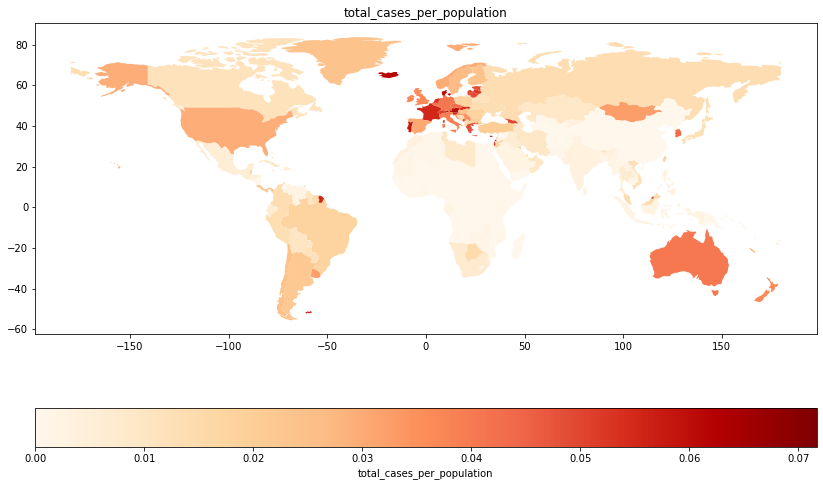

In [101]:
worldmap('new_cases')

- Europe was infected by COVID the most followed by Australia and the US.

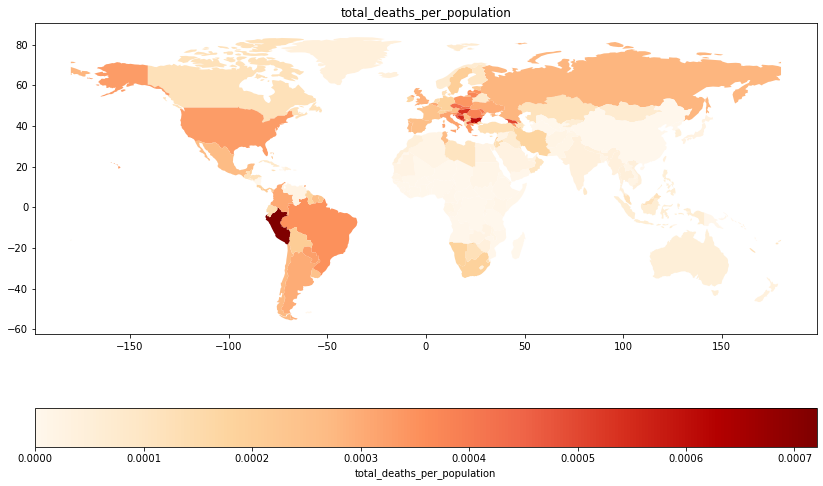

In [102]:
worldmap('new_deaths')

- South America, the US and some parts of Europe have high death count per population. However, when comparing death count to the number of people infected, it is a different story.

In [103]:
def worldmap_2(feature):
    table = merged_df
    table[f'{feature}_per_new_cases'] = (table[feature] / table['new_cases']) * 100
    table = table[table[f'{feature}_per_new_cases'] < 600] # remove any inf issues
    fig, ax = plt.subplots(1, 1, figsize=(14,9))
    name = 'total_' + feature.split('_')[1]
    plt.title(f'{name}_per_new_cases')
    table[[f'{feature}_per_new_cases', 'geometry']].plot(f'{feature}_per_new_cases', ax=ax, legend=True, legend_kwds={'label': f'{name}_per_new_cases', 'orientation':'horizontal'}, cmap='OrRd')
    plt.show()

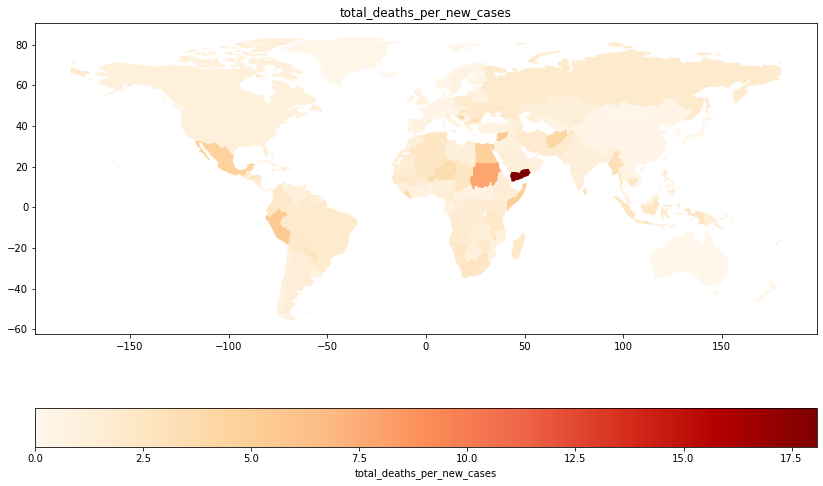

In [104]:
worldmap_2('new_deaths')

- In this case, Yemen and some parts of Africa alongside Peru and Mexico seem to have the highest deaths for its population.

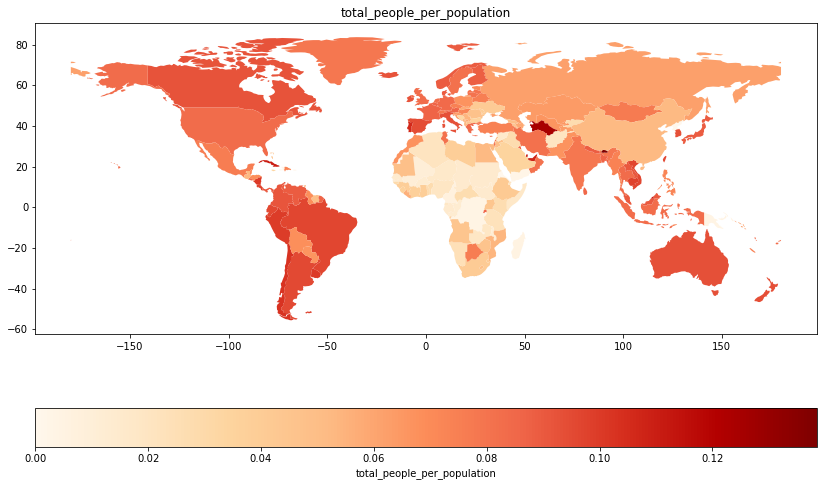

In [105]:
worldmap('new_people_vaccinated_smoothed')

- The world seems to be mostly vaccinated well apart from Africa.

## 4. Load

Chapter 3 was an in depth look into the data to create useful analytics that may be useful to report. Hence, not all the visuals will be used for a simplified dashboard to get an image of what is going on around the world. For the dashboard, the imported dataset will be exported as well as a number of the datasets used to create the visuals seen above.

In [106]:
d = df[df['iso_code'] == 'OWID_WRL'][['date', 'new_cases_smoothed', 'new_deaths_smoothed', 'new_vaccinations_smoothed']]
d

,date,new_cases_smoothed,new_deaths_smoothed,new_vaccinations_smoothed
204014,2020-01-22,0.00000,0.00000,0.00000
204015,2020-01-23,0.00000,0.00000,0.00000
204016,2020-01-24,0.00000,0.00000,0.00000
204017,2020-01-25,0.00000,0.00000,0.00000
204018,2020-01-26,0.00000,0.00000,0.00000
...,...,...,...,...
204940,2022-08-05,953741.14300,2433.71400,0.00000
204941,2022-08-06,1039604.85700,2524.00000,0.00000
204942,2022-08-07,1033869.42900,2525.14300,0.00000
204943,2022-08-08,1020751.42900,2499.71400,0.00000


In [107]:
a

,iso_code,location,population,total_cases,total_cases_per_population
0,OWID_AFR,Africa,1392394303.00000,12283127.00000,0.88216
1,OWID_ASI,Asia,4693235454.00000,170366465.00000,3.63004
2,OWID_EUR,Europe,748655221.00000,219771235.00000,29.35547
3,OWID_NAM,North America,596315269.00000,109627909.00000,18.38422
4,OWID_OCE,Oceania,44491772.00000,11726617.00000,26.35682
5,OWID_SAM,South America,433956670.00000,62659794.00000,14.43918


In [108]:
b

,iso_code,location,total_cases,total_deaths,total_deaths_per_total_cases
0,OWID_AFR,Africa,12283127.00000,256181.00000,2.08563
1,OWID_ASI,Asia,170366465.00000,1457633.00000,0.85559
2,OWID_EUR,Europe,219771235.00000,1891318.00000,0.86058
3,OWID_NAM,North America,109627909.00000,1482889.00000,1.35266
4,OWID_OCE,Oceania,11726617.00000,17017.00000,0.14511
5,OWID_SAM,South America,62659794.00000,1318633.00000,2.10443


In [109]:
c

,iso_code,location,population,people_vaccinated,people_vaccinated_per_population
0,OWID_AFR,Africa,1392394303.00000,371836386.00000,26.70482
1,OWID_ASI,Asia,4693235454.00000,3584029107.00000,76.36585
2,OWID_EUR,Europe,748655221.00000,516477947.00000,68.98742
3,OWID_NAM,North America,596315269.00000,441112084.00000,73.97296
4,OWID_OCE,Oceania,44491772.00000,29055001.00000,65.30421
5,OWID_SAM,South America,433956670.00000,369771574.00000,85.20933


In [110]:
e = population_table('total_deaths')
e

,iso_code,location,population,total_deaths,total_deaths_per_population
0,PER,Peru,33715472.00000,214694.00000,0.00637
1,BGR,Bulgaria,6885868.00000,37460.00000,0.00544
2,BIH,Bosnia and Herzegovina,3270943.00000,15930.00000,0.00487
3,HUN,Hungary,9709786.00000,46886.00000,0.00483
4,GEO,Georgia,3757980.00000,16869.00000,0.00449
5,MKD,North Macedonia,2103330.00000,9398.00000,0.00447
6,MNE,Montenegro,627859.00000,2756.00000,0.00439
7,HRV,Croatia,4060135.00000,16434.00000,0.00405
8,CZE,Czechia,10510750.00000,40587.00000,0.00386
9,MDA,Moldova,3061506.00000,11630.00000,0.00380


In [111]:
f = population_table('total_cases')
f

,iso_code,location,population,total_cases,total_cases_per_population
0,FRO,Faeroe Islands,52888.00000,34658.00000,0.65531
1,CYP,Cyprus,896007.00000,568383.00000,0.63435
2,GIB,Gibraltar,32670.00000,19999.00000,0.61215
3,SMR,San Marino,33746.00000,20074.00000,0.59486
4,AND,Andorra,79034.00000,45793.00000,0.57941
5,DNK,Denmark,5854240.00000,3245898.00000,0.55445
6,ISL,Iceland,370335.00000,203162.00000,0.54859
7,AUT,Austria,8922082.00000,4842843.00000,0.54279
8,SPM,Saint Pierre and Miquelon,5883.00000,3112.00000,0.52898
9,PRT,Portugal,10290103.00000,5367395.00000,0.52161


In [112]:
g = df.loc[df['iso_code'] == 'OWID_WRL', ['people_vaccinated', 'people_fully_vaccinated']].max()
g = pd.DataFrame(g, columns=['value']).reset_index()
g

,index,value
0,people_vaccinated,5312282099.00000
1,people_fully_vaccinated,4883058918.00000


In [113]:
h = df.loc[df['iso_code'] == 'OWID_WRL', ['people_vaccinated', 'population']].max()
h = pd.DataFrame(h, columns=['value']).reset_index()
h

,index,value
0,people_vaccinated,5312282099.00000
1,population,7909295152.00000


In [114]:
i = world_vaccination
i

,iso_code,location,population,people_vaccinated,people_fully_vaccinated
0,OWID_AFR,Africa,1392394303.00000,371836386.00000,293278107.00000
1,OWID_ASI,Asia,4693235454.00000,3584029107.00000,3352719597.00000
2,OWID_EUR,Europe,748655221.00000,516477947.00000,494426625.00000
3,OWID_NAM,North America,596315269.00000,441112084.00000,382637684.00000
4,OWID_OCE,Oceania,44491772.00000,29055001.00000,27871012.00000
5,OWID_SAM,South America,433956670.00000,369771574.00000,332125893.00000


In [115]:
j = countries.groupby('year').agg({'new_cases':'sum'}).reset_index()
j

,year,new_cases
0,2020,83043831.00000
1,2021,205300814.00000
2,2022,297004520.00000


In [116]:
k = countries.groupby('year').agg({'new_deaths':'sum'}).reset_index()
k

,year,new_deaths
0,2020,1872625.00000
1,2021,3540735.00000
2,2022,968042.00000


In [117]:
l = countries.groupby('year').agg({'new_people_vaccinated_smoothed':'sum'}).reset_index()
l

,year,new_people_vaccinated_smoothed
0,2020,5561297.00000
1,2021,3934859362.00000
2,2022,738016345.00000


In [122]:
m = countries
m.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,month,year,day
0,AFG,Asia,Afghanistan,2020-02-24,5.00000,5.00000,0.00000,0.00000,0.00000,0.00000,0.12500,0.12500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.33000,40099462.00000,54.42200,18.60000,2.58100,1.33700,1803.98700,0.00000,597.02900,9.59000,0.00000,0.00000,37.74600,0.50000,64.83000,0.51100,0.00000,0.00000,0.00000,0.00000,2,2020,24
1,AFG,Asia,Afghanistan,2020-02-25,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.33000,40099462.00000,54.42200,18.60000,2.58100,1.33700,1803.98700,0.00000,597.02900,9.59000,0.00000,0.00000,37.74600,0.50000,64.83000,0.51100,0.00000,0.00000,0.00000,0.00000,2,2020,25
2,AFG,Asia,Afghanistan,2020-02-26,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.33000,40099462.00000,54.42200,18.60000,2.58100,1.33700,1803.98700,0.00000,597.02900,9.59000,0.00000,0.00000,37.74600,0.50000,64.83000,0.51100,0.00000,0.00000,0.00000,0.00000,2,2020,26
3,AFG,Asia,Afghanistan,2020-02-27,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.33000,40099462.00000,54.42200,18.60000,2.58100,1.33700,1803.98700,0.00000,597.02900,9.59000,0.00000,0.00000,37.74600,0.50000,64.83000,0.51100,0.00000,0.00000,0.00000,0.00000,2,2020,27
4,AFG,Asia,Afghanistan,2020-02-28,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12500,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0

In [119]:
import pyodbc
from sqlalchemy import create_engine
import urllib

SERVER_NAME = 'DESKTOP-GR6T3L7'
DATABASE_NAME = 'CovidV2'

# connection string
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER=' + SERVER_NAME + '; \
                       DATABASE=' + DATABASE_NAME + '; \
                       Trusted_Connection=yes')

# cursor to extract data
cursor = conn.cursor()

# Use this to connect for saving data
quoted = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER='+SERVER_NAME+'; \
                       DATABASE='+DATABASE_NAME+'; \
                       Trusted_Connection=yes')

# save the dataset into SQL database
engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))
df.to_sql('initial_dataset', schema='dbo', con=engine, if_exists='replace')
a.to_sql('a', schema='dbo', con=engine, if_exists='replace')
b.to_sql('b', schema='dbo', con=engine, if_exists='replace')
c.to_sql('c', schema='dbo', con=engine, if_exists='replace')
d.to_sql('d', schema='dbo', con=engine, if_exists='replace')
e.to_sql('e', schema='dbo', con=engine, if_exists='replace')
f.to_sql('f', schema='dbo', con=engine, if_exists='replace')
g.to_sql('g', schema='dbo', con=engine, if_exists='replace')
h.to_sql('h', schema='dbo', con=engine, if_exists='replace')
i.to_sql('i', schema='dbo', con=engine, if_exists='replace')
j.to_sql('j', schema='dbo', con=engine, if_exists='replace')
k.to_sql('k', schema='dbo', con=engine, if_exists='replace')
l.to_sql('l', schema='dbo', con=engine, if_exists='replace')
m.to_sql('m', schema='dbo', con=engine, if_exists='replace')

# close port
cursor.close()
conn.close( 
)
print('Dataset appended.')

Dataset appended.


**END**